In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge

from batcar import BatCar
from batcar.model_updater import ModelUpdater
from batcar.model_updater.data_selectors import AllSelector, RecentSelector
from batcar.model_updater.wrappers import FrameIO
from batcar.update_trigger import PeriodicTrigger

In [3]:
plt.style.use('makina-notebook')

# Generate Synthetic Data

Text(0.5, 1.0, 'Synthetic Data')

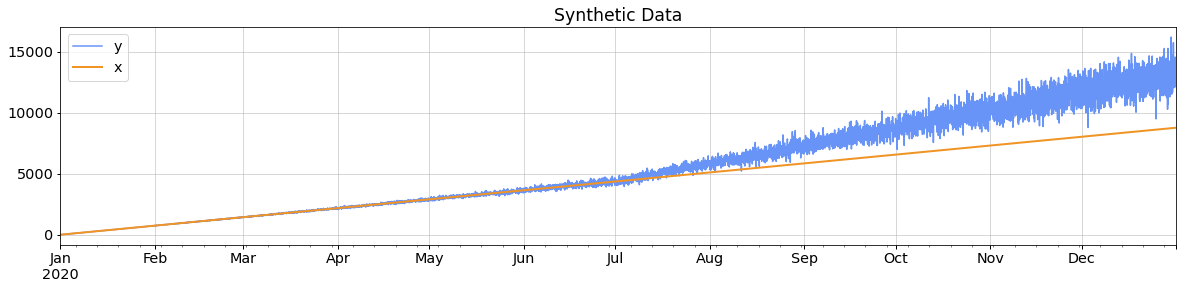

In [4]:
data_times = pd.date_range('2020-01-01 00:00:00', '2021-01-01 00:00:00', freq='1h', closed='left')

n_samples = len(data_times)
n_phase1 = int(n_samples / 2)
n_phase2 = n_samples - n_phase1

x = pd.DataFrame(np.arange(n_samples).reshape(-1, 1), index=data_times, columns=['x'])

y1_clean = np.arange(n_phase1)
y2_clean = np.arange(n_phase2) * 2 + y1_clean[-1]

y_clean = pd.DataFrame(np.concatenate([y1_clean, y2_clean]), index=data_times, columns=['y'])
y_noise = np.random.randn(*y_clean.shape) * (y_clean * 0.03) * (x.to_numpy()*0.0003)

y = y_clean + y_noise

ax = y.plot.line(figsize=(20,4))
ax = x.plot.line(lw=2, ax=ax)
ax.set_title('Synthetic Data')

# Run BatCar

## Drive

In [5]:
%%time

model = FrameIO(Ridge())

update_interval = '31 days'

data_selector = RecentSelector(744)
model_updater = ModelUpdater.from_generator(model, data_selector=data_selector)

batcar = BatCar(update_interval, model_updater)
batcar.drive(x, y, batch_size=update_interval, batch_update=True)

100%|██████████| 12/12 [00:00<00:00, 20.54it/s]

|   episode | build_time          |
|----------:|:--------------------|
|         0 | 2020-02-01 00:00:00 |
|         1 | 2020-03-03 00:00:00 |
|         2 | 2020-04-03 00:00:00 |
|         3 | 2020-05-04 00:00:00 |
|         4 | 2020-06-04 00:00:00 |
|         5 | 2020-07-05 00:00:00 |
|         6 | 2020-08-05 00:00:00 |
|         7 | 2020-09-05 00:00:00 |
|         8 | 2020-10-06 00:00:00 |
|         9 | 2020-11-06 00:00:00 |
|        10 | 2020-12-07 00:00:00 |
CPU times: user 572 ms, sys: 21.6 ms, total: 594 ms
Wall time: 658 ms



## Overall Prediction

Text(0.5, 1.0, "{'mae': 287.1569386812578}")

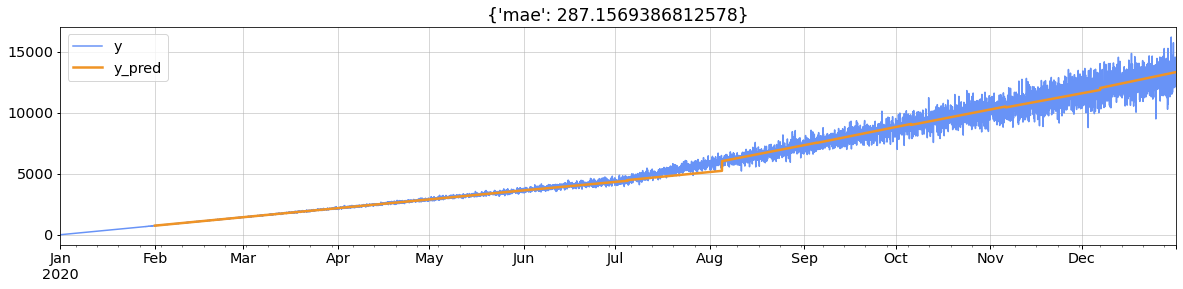

In [6]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4))
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=2.5)
ax.legend()
ax.set_title(y_eval.mean().to_dict())

## Episode-wise Performance

In [7]:
test_perform = batcar.get_test_performance()
test_perform

,mae
episode_id,
-1,NaN
0,9.443908
1,24.852264
2,49.545978
3,77.688738
4,126.545893
5,441.486625
6,280.822828
7,369.741059


## What-if Performance
- Performance evaluation with assuming that the model updates did not happen. 
- For instance, samples in the i-th episode are evaluated by the model in the (i-1)-th episode.

In [8]:
asif_pred, asif_eval = batcar.imagine_what_if()
asif_test_perform = batcar.get_test_performance(eval_table=asif_eval)

### Comparison in Predicted Values

Text(0.5, 1.0, "{'mae': 287.1569386812578}")

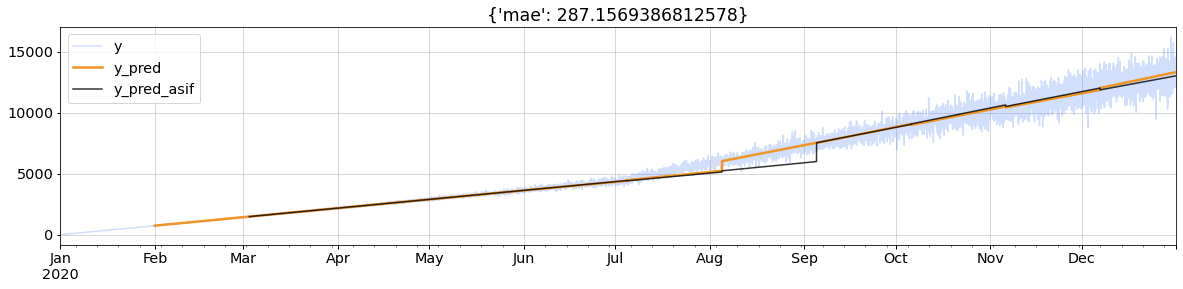

In [9]:
y_pred = batcar.pred_table
y_eval = batcar.eval_table

ax = y.plot.line(figsize=(20,4), alpha=0.3)
ax = y_pred.iloc[:, 0].rename('y_pred').plot.line(ax=ax, lw=2.5)
ax = asif_pred.iloc[:, 0].rename('y_pred_asif').plot.line(ax=ax, lw=1.5, color='black', alpha=0.8)
ax.legend()
ax.set_title(y_eval.mean().to_dict())

### Comparison in Overall Performance

In [10]:
pd.concat([
    y_eval.mean().rename('y_pred'), 
    asif_eval.mean().rename('y_pred_asif')
], axis=1, keys=['y_pred', 'y_pred_asif'])

,y_pred,y_pred_asif
mae,287.156939,410.035627


### Comparison in Episode-wise Performance

In [11]:
diff_perform = (test_perform - asif_test_perform).abs()

pd.concat(
    [test_perform, asif_test_perform, diff_perform], 
    axis=1, 
    keys=['BatCar', 'What If', 'Abs Error']
)

,BatCar,What If,Abs Error
,mae,mae,mae
episode_id,,,
-1,NaN,NaN,NaN
0,9.443908,NaN,NaN
1,24.852264,24.854819,0.002555
2,49.545978,49.644091,0.098113
3,77.688738,77.653669,0.035069
4,126.545893,124.418356,2.127537
5,441.486625,509.502429,68.015803
6,280.822828,1124.547757,843.724929
